# Sistemas de recomendación.

Ahora veremos cómo crear un sistema de recomendación. Con este fin exploraremos diferentes propiedades de los sistemas de recomendación, desarrollaremos y evaluaremos un sistema de recomendación colaborativa.


<div style="text-align: right"> <sub>Referencia: Igual L. & Seguí, S. (2017). *Introduction to Data Science*. Springer. Código fuente: https://github.com/DataScienceUB/introduction-datascience-python-book </sub> </div>

In [2]:
import matplotlib.pylab as plt

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

## Descripción de datos

Trabajaremos con el bien conocido conjunto de datos MovieLens (http://grouplens.org/datasets/movielens/). Este conjunto de datos se construyó inicialmente para ayudar a los participantes en el Premio Netflix. Hoy en día, podemos encontrar varias versiones de este conjunto de datos con diferentes tipos de datos, desde la versión de 100k muestras hasta la versión de muestra de 20m.
Aunque se espera que el rendimiento en un conjunto de datos más grande sea mejor, trabajaremos con el conjunto de datos más pequeño: MovieLens *100K Dataset (ml-100k-zip)*. Trabajar con esta versión lite tiene el beneficio de menos costos computacionales, mientras que también obtendremos las habilidades requeridas en los sistemas de recomendación basados en el usuario.

Con una máquina Unix, el conjunto de datos se puede descargar con el siguiente código:

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
!unzip ml-100k.zip 

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Puede encontrar el archivo descomprimido en esta misma carpeta.

Una vez que haya descargado y descomprimido el archivo en un directorio, puede crear un DataFrame con el siguiente código:

In [4]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from math import isnan


# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(3),encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("La BD has "+ str(data.shape[0]) +" ratings")
print("La BD has ", data.user_id.nunique()," users")
print("La BD has ", data.movie_id.nunique(), " movies")
print(data.head())

La BD has 100000 ratings
La BD has  943  users
La BD has  1682  movies
   user_id         title  movie_id  rating release_date sex  age
0      196  Kolya (1996)       242       3  24-Jan-1997   M   49
1      305  Kolya (1996)       242       5  24-Jan-1997   M   23
2        6  Kolya (1996)       242       4  24-Jan-1997   M   42
3      234  Kolya (1996)       242       4  24-Jan-1997   M   60
4       63  Kolya (1996)       242       3  24-Jan-1997   M   31


In [5]:
data.s

TypeError: 'numpy.int32' object is not callable

Si explora el conjunto de datos en detalle, verá que consiste en:
<ul>
<li> 100.000 calificaciones de 943 usuarios de 1682 películas. Las calificaciones son de 1 a 5. </li>
<li> Cada usuario ha calificado al menos 20 películas. </li>
<li> Información demográfica simple para los usuarios (edad, sexo, ocupación, código postal) </li>
</ul>

## Crear un filtro colaborativo (CF) para el conjunto de datos de Movilens
La idea detrás de cualquier sistema de recomendación es sugerir o recomendar elementos que puedan ser de interés para el usuario. Si pensamos en el conjunto de datos de película y un sistema de recomendación de película, el objetivo consistirá en recomendar aquellas películas de uso de un "usuario" dado que es más probable que se interesen por él. Por lo tanto, el problema se puede tomar al predecir las calificaciones de las películas invisibles del "usuario" dado y recomendar aquellas con la calificación más alta predicha.

<br> La siguiente tabla ilustra el problema. Este conjunto de datos de juguetes consiste en 4 usuarios y 4 elementos. Los usuarios 1, 2 y 3 han visto todas las películas, mientras que el usuario 3 solo ha visto Superman y Star Wars. Entonces, el problema consiste en la predicción de qué película, Matrix o Spiderman serán más probables para el usuario 4.
<table style="width:60%">
  <tr>
    <td></td>
    <td>Superman</td> 
    <td>Star Wars 1</td>
    <td>Matrix</td>
    <td>Spiderman</td>
    
  </tr>
  <tr>
    <td>user1</td>
    <td>3</td> 
    <td>3.5</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user2</td>
    <td>3.5</td> 
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>user3</td>
    <td>3</td> 
    <td>4</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user4</td>
    <td>3.5</td> 
    <td>5</td>
    <td><font color="red"><b>¿?</b></font></td>
    <td><font color="red"><b>¿?</b></font></td>
  </tr>
</table>
<br><br><br><br>


Para crear un sistema de recomendación colaborativa, tendremos que definir: 1) una función de predicción, 2) una función de similitud de usuario y 3) una función de evaluación.

### Función de predicción:
La función de predicción detrás del CF se basará en las clasificaciones de películas de usuarios similares.
Entonces, para recomendar una película, $ p $, de un conjunto de películas, $ P $, a un usuario dado, $ a $, primero tenemos que ver el conjunto de usuarios, $ B $, que ya han visto $ p $. Entonces, necesitamos ver la similitud de sabor entre estos usuarios en $ B $ y el usuario $ a $. La función de predicción más simple para un usuario $ a $ y una película $ p $ se puede definir de la siguiente manera:

$$pred(a,p) = \frac{\sum_{b \in B}{sim(a,b)*(r_{b,p})}}{\sum_{b \in B}{sim(a,b)}}$$

donde $ sim (a, b) $ es la similitud entre el usuario $ a $ y el usuario $ b $, $ B $ es el conjunto de usuarios en el conjunto de datos que ya han visto $ p $ y $ r_ {b, p} $ es la calificación de $ p $ por $ b $.

<h3>Similaridad entre usuarios</h3>
El cálculo de la similitud entre elementos es uno de los pasos más críticos en los algoritmos CF. La idea básica detrás del cálculo de similitud entre dos usuarios $ a $ y $ b $ es que primero podemos aislar el conjunto $ P $ de los elementos calificados por ambos usuarios, y luego aplicar una técnica de cálculo de similitud para determinar la similitud.

El conjunto de *common_movies* se puede obtener con el siguiente código:

In [11]:
# dataframe with the data from user 1
data_user_1 = data[data.user_id==1]
# dataframe with the data from user 2
data_user_2 = data[data.user_id==6]
# We first compute the set of common movies
common_movies = set(data_user_1.movie_id).intersection(data_user_2.movie_id)
print("\nNumber of common movies",len(common_movies),'\n')

# creat the subdataframe with only with the common movies
mask = (data_user_1.movie_id.isin(common_movies))
data_user_1 = data_user_1[mask]
print (data_user_1[['title','rating']].head())

mask = (data_user_2.movie_id.isin(common_movies))
data_user_2 = data_user_2[mask]
print (data_user_2[['title','rating']].head())


Number of common movies 96 

                                    title  rating
14                           Kolya (1996)       5
940                Raising Arizona (1987)       4
1306  Truth About Cats & Dogs, The (1996)       5
2677                          Babe (1995)       1
3073   Four Weddings and a Funeral (1994)       3
                                    title  rating
2                            Kolya (1996)       4
885                Raising Arizona (1987)       5
1255  Truth About Cats & Dogs, The (1996)       2
2636                          Babe (1995)       4
3022   Four Weddings and a Funeral (1994)       3


Una vez que se ha obtenido el conjunto de calificaciones para todas las películas comunes a los dos usuarios, podemos calcular la similitud del usuario. Estas son algunas de las funciones de similitud más comunes utilizadas en los métodos de CF:
   <ul>
    <li>Distancia Euclideana</li>
    $$sim(a,b) = \sqrt{\sum_{p \in P}{(r_{a,p} - r_{b,p})^2}}$$
    <br>
    <li>Correlación de Pearson</li>
    $$sim(a,b) = \frac{\sum_{p\in P} (r_{a,p}-\bar{r_a})(r_{b,p}-\bar{r_b})}{\sqrt{\sum_{p \in P}(r_{a,p}-\bar{r_a})²}\sqrt{\sum_{p \in P}(r_{b,p}-\bar{r_b})²}}$$
    <br>
    <li>Distancia del Coseno</li>
    $$ sim(a,b) = \frac{\vec{a}· \vec{b}}{|\vec{a}| * |\vec{b}|}$$
    <br>
    </ul>
  
<br>
Dónde:

* $ sim (a, b) $ es la similitud entre el usuario "a" y el usuario "b"
* $ P $ es el conjunto de películas clasificadas comunes por el usuario "a" y "b"
* $ r_{a, p} $ es la clasificación de la película "p" por el usuario "a"
* $ \bar {r_a} $ es la calificación media dada por el usuario "a"

<br>

<h4>Algunas cosas que tener en cuenta</h4>
<ul>
<li>La correlación de Pearson suele funcionar mejor que la distancia euclidiana ya que se basa más en el ranking que en los valores.</li>
<li>La distancia del coseno generalmente se utiliza cuando nuestros datos son binarios / unarios, es decir, como "versus" no como "comprar" o "no comprar".</li>
<li>¿Qué sucede si dos usuarios tienen muy pocos elementos en común?</li>
</ul>



Vamos a definir una función para calcular la similitud de los usuarios

In [12]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
import seaborn as sns;

# Returns a distance-based similarity score for person1 and person2
def SimEuclid(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')    
    if len(rep)==0:
        return 0
    if(len(rep)<min_common_items):
        return 0
    #return distEuclid(rep['rating_x'],rep['rating_y']) 
    return 1.0/(1.0+euclidean(rep['rating_x'],rep['rating_y'])) 

# Returns a pearsonCorrealation-based similarity score for person1 and person2
def SimPearson(DataFrame,User1,User2,min_common_items=1):
    # GET MOVIES OF USER1
    movies_user1=DataFrame[DataFrame['user_id'] ==User1 ]
    # GET MOVIES OF USER2
    movies_user2=DataFrame[DataFrame['user_id'] ==User2 ]
    
    # FIND SHARED FILMS
    rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
    if len(rep)==0:
        return 0    
    if(len(rep)<min_common_items):
        return 0    
    res=pearsonr(rep['rating_x'],rep['rating_y'])[0]
    if(isnan(res)):
        return 0
    return res


Veamos qué tan similares son el usuario 1 con 8 y 1 con 31

In [13]:
print("Euclidean Similarity",SimEuclid(data,1,8))
print( "Pearson Similarity",SimPearson(data,1,8))
print( "-----")
print( "Euclidean Similarity",SimEuclid(data,1,31))
print( "Pearson Similarity",SimPearson(data,1,31))


Euclidean Similarity 0.1566130288262323
Pearson Similarity 0.6920863660773593
-----
Euclidean Similarity 0.1757340838011157
Pearson Similarity -0.09221388919541468


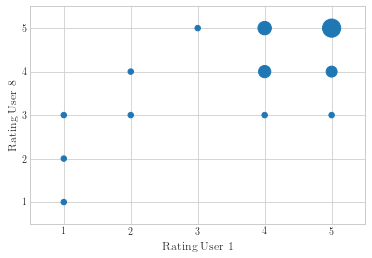

In [14]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==8 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)

fig = plt.figure(figsize=(6,4))
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(8))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre18.png",dpi= 300, bbox_inches='tight')
plt.show()

Y con el usuario 31:

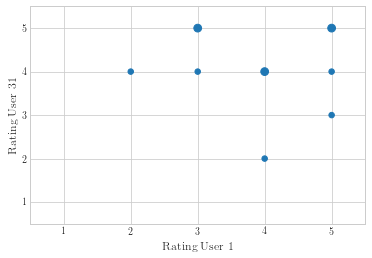

In [15]:
movies_user1=data[data['user_id'] ==1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==31 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]

fig = plt.figure(figsize=(6,4))
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(31))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre131.png",dpi= 300, bbox_inches='tight')
plt.show()
